In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from utils import config, utils

In [2]:
# Define the target and features
TARGET = "label"
FEATURES = ["text",]

In [3]:
df = pd.read_csv("../res/prepared/cryptonews.csv")
df_cv = pd.read_csv("../res/prepared/indian_financial_news.csv")

In [4]:
config.SENTIMENTS = df[TARGET].unique().tolist()
config.SENTIMENTS

['negative', 'neutral', 'positive']

## Model training

### Pretrained

#### Ollama
Due to poor performance and long execution times, this model will no longer be evaluated. The results can be found in the notebook located at `src/archive/llm-ollama.ipynb`

In [5]:
ollama_model = "llama3.1:latest"

In [6]:
# ollama_pipeline = utils.OllamaPipeline(
#     df=df_tweets,
#     features=FEATURES,
#     target=TARGET,
#     ollama_model=ollama_model,
#     model_name=ollama_model,
# )

In [7]:
# ollama_pipeline.evaluate()

#### Huggingface

In [8]:
# from transformers import pipeline
# import tqdm

# pipe = pipeline("text-classification", model="ProsusAI/finbert")

In [9]:
# display(df_tweets["text"])

In [10]:
# y_pred = []

# for idx, row in tqdm.tqdm(df_tweets.iterrows(), desc="Predicting sentiment"):
#     try:
#         result = pipe(
#             #{"text": row["title"], "text_pair": row["text"]},
#             {"text": row["text"]},
#             truncation=True  
#         )
#         y_pred.append(result)
#     except Exception as e:
#         print(idx, "|", e, "|", row["text"])
#         y_pred.append({"label": "N/A"})
    
# df_tweets["y_pred"] = y_pred

In [11]:
# df_tweets.head()

In [12]:
# df_tweets["pred_sentiment"] = df_tweets["y_pred"].apply(lambda x: x["label"])
# df_tweets["pred_sentiment"] = df_tweets["pred_sentiment"].replace({"POS": "positive", "NEU": "neutral", "NEG": "negative"})
# df_tweets.head()

In [13]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# cm = confusion_matrix(df_tweets["label"], df_tweets["pred_sentiment"], labels=config.SENTIMENTS, normalize="true")
# print(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config.SENTIMENTS)
# disp.plot(cmap=plt.cm.Blues)

### Supervised

#### NLTK-Randomforest

In [14]:
nltk_rf_model = utils.CustomPipeline(
    df,
    FEATURES,
    TARGET, 
    df_cv = df_cv,
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer(False)),
                ('tfidf', TfidfVectorizer())
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_rf"
)

In [15]:
nltk_rf_model.fit(False)
nltk_rf_model.fit(True)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  26.5s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  30.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  14.5s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  15.8s


Classification Report for nltk_rf - unbalanced train data:


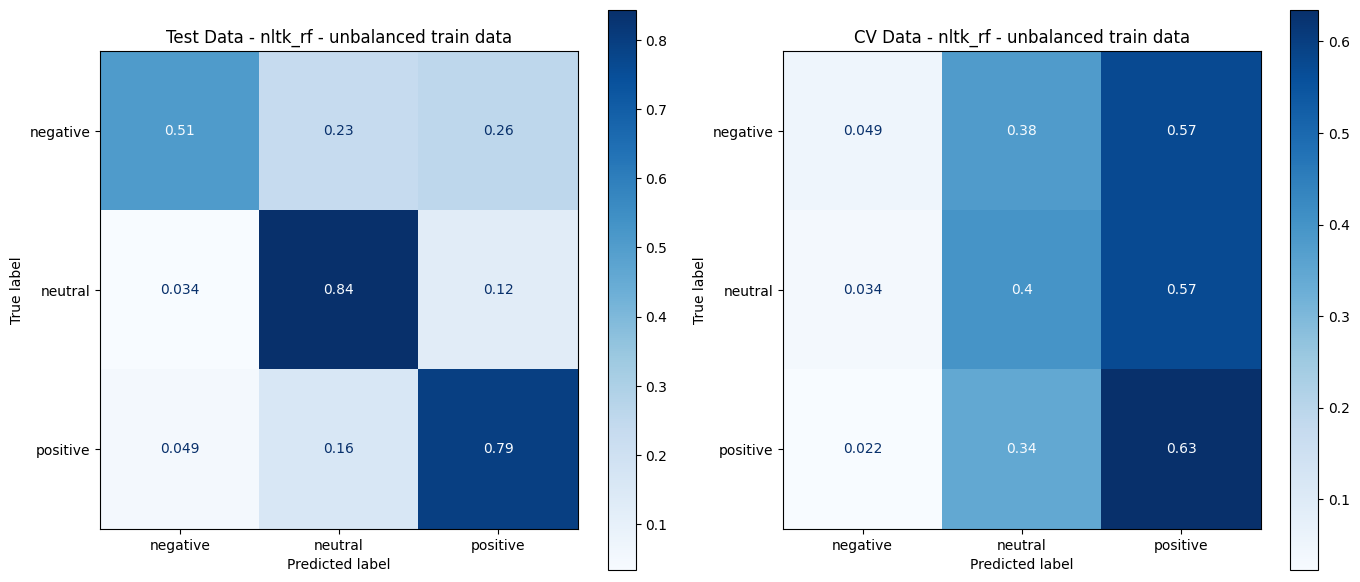

              precision    recall  f1-score   support

    negative       0.75      0.51      0.61       744
     neutral       0.72      0.84      0.77      1304
    positive       0.79      0.79      0.79      1661

    accuracy                           0.75      3709
   macro avg       0.75      0.72      0.72      3709
weighted avg       0.76      0.75      0.75      3709

              precision    recall  f1-score   support

    negative       0.47      0.05      0.09      8987
     neutral       0.35      0.40      0.37      8987
    positive       0.36      0.63      0.46      8987

    accuracy                           0.36     26961
   macro avg       0.39      0.36      0.31     26961
weighted avg       0.39      0.36      0.31     26961

Classification Report for nltk_rf - balanced train data:


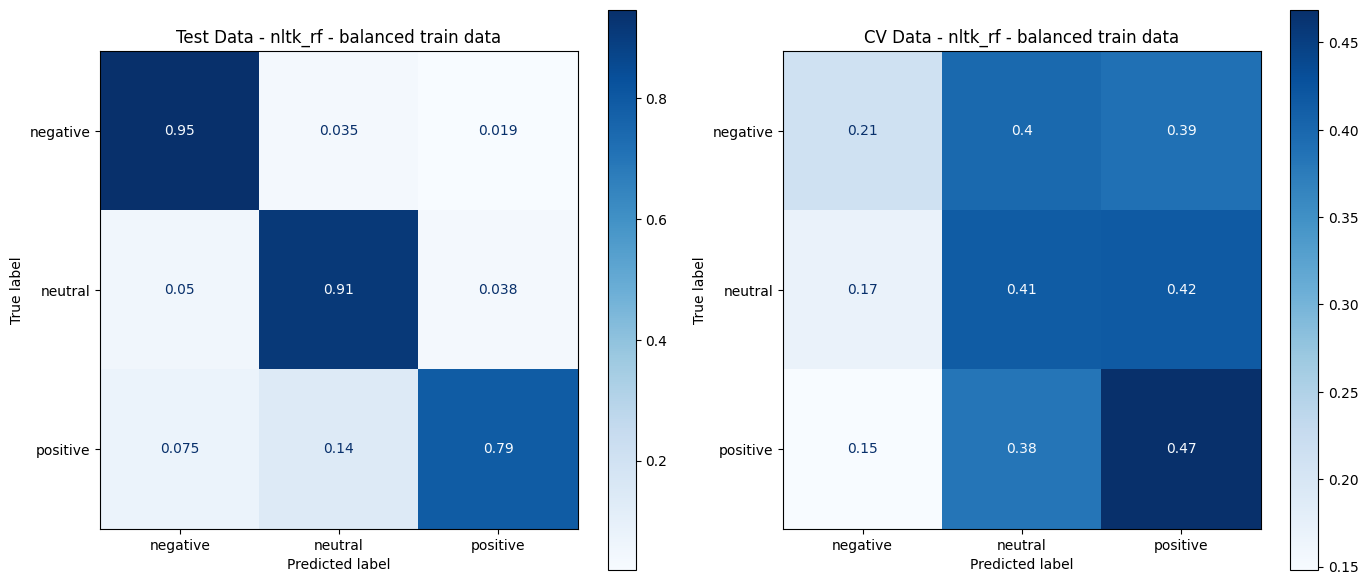

              precision    recall  f1-score   support

    negative       0.79      0.95      0.86       744
     neutral       0.82      0.91      0.87      1304
    positive       0.95      0.79      0.86      1661

    accuracy                           0.86      3709
   macro avg       0.86      0.88      0.86      3709
weighted avg       0.87      0.86      0.86      3709

              precision    recall  f1-score   support

    negative       0.40      0.21      0.28      8987
     neutral       0.35      0.41      0.38      8987
    positive       0.37      0.47      0.41      8987

    accuracy                           0.37     26961
   macro avg       0.37      0.37      0.36     26961
weighted avg       0.37      0.37      0.36     26961



In [16]:
nltk_rf_model.evaluate(False)
nltk_rf_model.evaluate(True)

In [17]:
nltk_rf_model.dump("../res/models")

#### NLTK-NGrams-RDF

In [18]:
nltk_rf_ngram_1_3_model = utils.CustomPipeline(
    df,
    FEATURES,
    TARGET, 
    df_cv = df_cv,
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer(True)),
                ('tfidf', (TfidfVectorizer(tokenizer=None, preprocessor=None, ngram_range=(1, 3)))),
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_rf_n_gram_1_3"
)

In [19]:
nltk_rf_ngram_1_3_model.fit(False)
nltk_rf_ngram_1_3_model.fit(True)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  20.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 3.4min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  13.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 1.4min


Classification Report for nltk_rf_n_gram_1_3 - balanced train data:


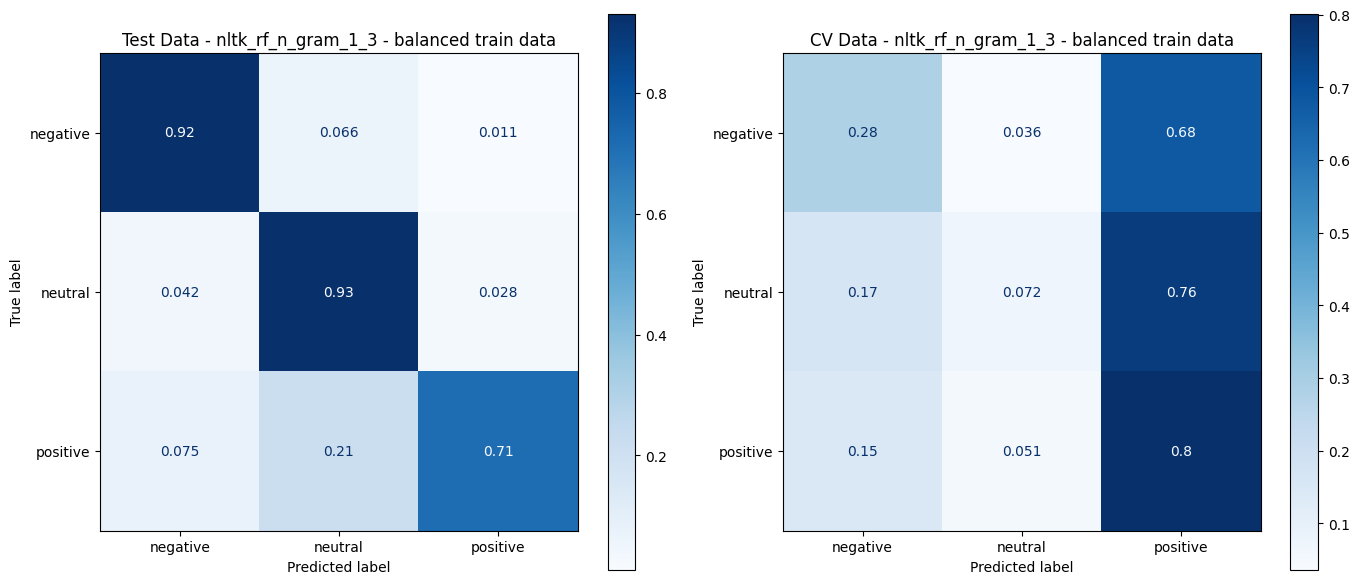

              precision    recall  f1-score   support

    negative       0.79      0.92      0.85       744
     neutral       0.75      0.93      0.83      1304
    positive       0.96      0.71      0.82      1661

    accuracy                           0.83      3709
   macro avg       0.84      0.86      0.83      3709
weighted avg       0.85      0.83      0.83      3709

              precision    recall  f1-score   support

    negative       0.47      0.28      0.35      8987
     neutral       0.45      0.07      0.12      8987
    positive       0.36      0.80      0.49      8987

    accuracy                           0.39     26961
   macro avg       0.43      0.39      0.32     26961
weighted avg       0.43      0.39      0.32     26961



In [20]:
nltk_rf_ngram_1_3_model.evaluate(False)
nltk_rf_ngram_1_3_model.evaluate(True)

In [21]:
nltk_rf_ngram_1_3_model.dump("../res/models")

#### NLTK-NGrams-SVC

In [22]:
from sklearn.svm import SVC
nltk_svc_ngram_1_3_model = utils.CustomPipeline(
    df,
    FEATURES,
    TARGET, 
    df_cv = df_cv,
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer(True)),
                ('tfidf', (TfidfVectorizer(preprocessor=None, tokenizer=None, ngram_range=(1, 3)))),
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", SVC(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_svc_n_gram_1_3"
)

In [23]:
nltk_svc_ngram_1_3_model.fit(True)
nltk_svc_ngram_1_3_model.fit(False)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   6.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  18.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  11.9s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 1.8min


Classification Report for nltk_svc_n_gram_1_3 - unbalanced train data:


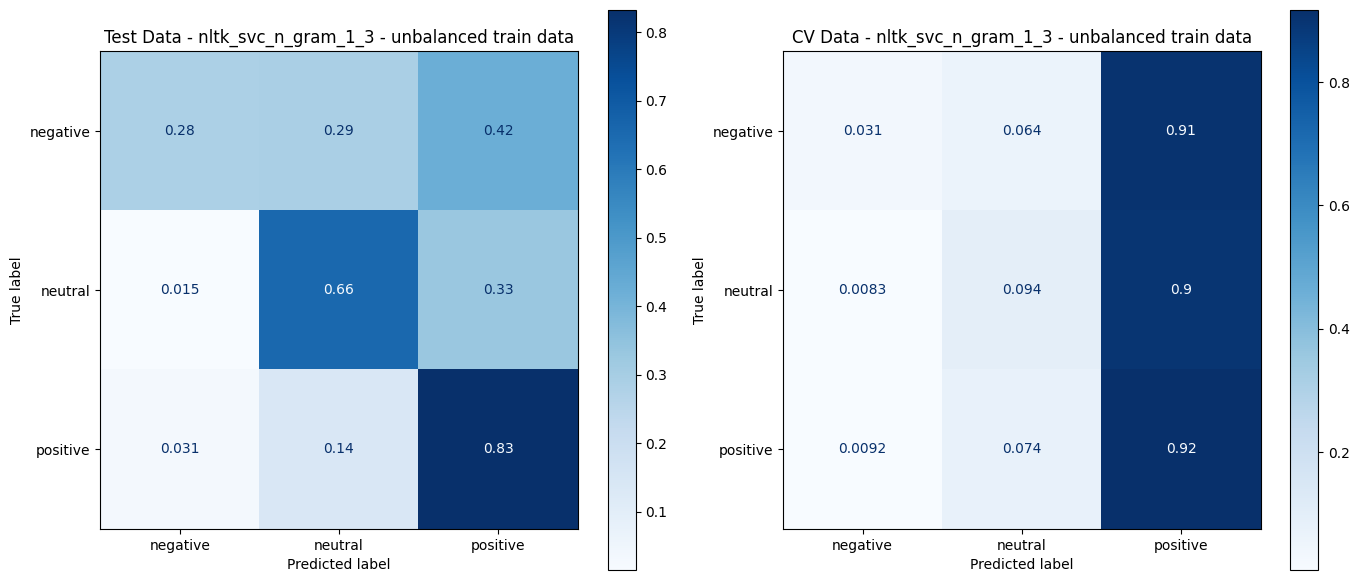

              precision    recall  f1-score   support

    negative       0.75      0.28      0.41       744
     neutral       0.66      0.66      0.66      1304
    positive       0.65      0.83      0.73      1661

    accuracy                           0.66      3709
   macro avg       0.69      0.59      0.60      3709
weighted avg       0.67      0.66      0.64      3709

              precision    recall  f1-score   support

    negative       0.64      0.03      0.06      8987
     neutral       0.41      0.09      0.15      8987
    positive       0.34      0.92      0.49      8987

    accuracy                           0.35     26961
   macro avg       0.46      0.35      0.24     26961
weighted avg       0.46      0.35      0.24     26961

Classification Report for nltk_svc_n_gram_1_3 - balanced train data:


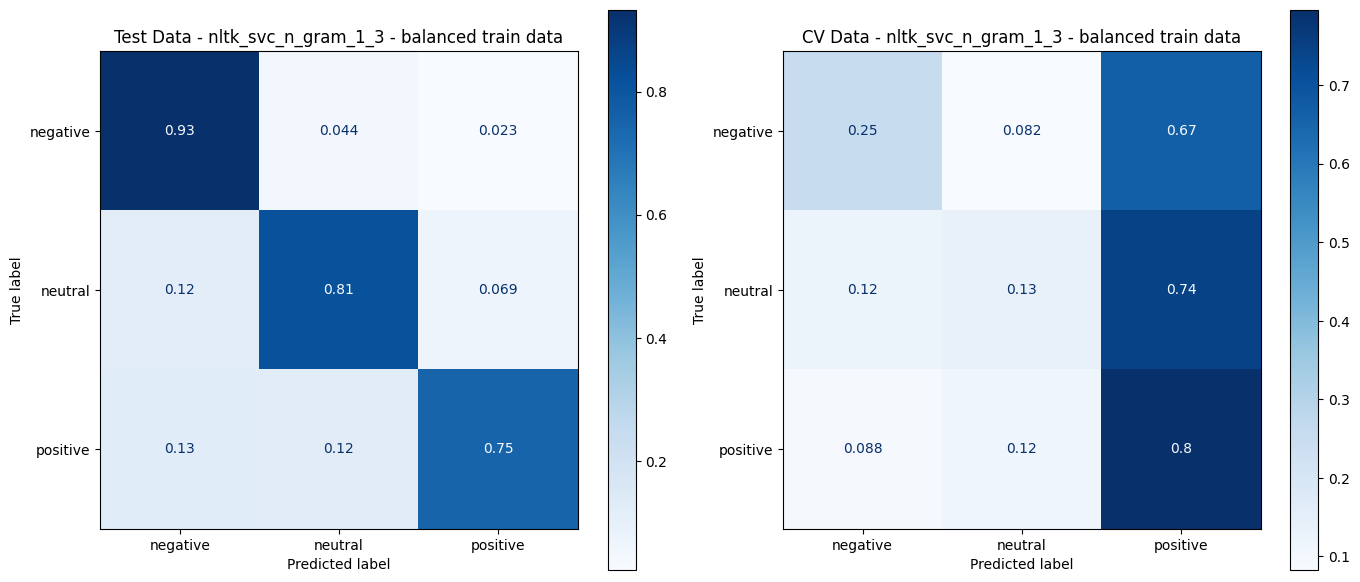

              precision    recall  f1-score   support

    negative       0.66      0.93      0.77       744
     neutral       0.82      0.81      0.81      1304
    positive       0.92      0.75      0.83      1661

    accuracy                           0.81      3709
   macro avg       0.80      0.83      0.80      3709
weighted avg       0.83      0.81      0.81      3709

              precision    recall  f1-score   support

    negative       0.55      0.25      0.35      8987
     neutral       0.40      0.13      0.20      8987
    positive       0.36      0.80      0.50      8987

    accuracy                           0.39     26961
   macro avg       0.44      0.39      0.35     26961
weighted avg       0.44      0.39      0.35     26961



In [24]:
nltk_svc_ngram_1_3_model.evaluate(False)
nltk_svc_ngram_1_3_model.evaluate(True)

In [25]:
nltk_svc_ngram_1_3_model.dump("../res/models")